In [1]:
import cv2
import numpy as np
from csi_camera import CSI_Camera
import IPython.display
import PIL.Image
from io import BytesIO
import ipywidgets as widgets

In [2]:
show_fps = True

In [3]:
# Simple draw label on an image; in our case, the video frame
def draw_label(cv_image, label_text, label_position):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.5
    color = (255,255,255)
    # You can get the size of the string with cv2.getTextSize here
    cv2.putText(cv_image, label_text, label_position, font_face, scale, color, 1, cv2.LINE_AA)

In [4]:
# Read a frame from the camera, and draw the FPS on the image if desired
# Return an image
def read_camera(csi_camera, display_fps):
    _ , camera_image=csi_camera.read()
    if display_fps:
        draw_label(camera_image, "Frames Displayed (PS): "+str(csi_camera.last_frames_displayed),(10,20))
        draw_label(camera_image, "Frames Read (PS): "+str(csi_camera.last_frames_read),(10,40))
    return camera_image

In [5]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def show_array_IPython():
    display_id = None
    def wrapper(array: np.ndarray, fmt='jpeg'):
        nonlocal display_id
        f = BytesIO()
        PIL.Image.fromarray(array).save(f, fmt)
        obj = IPython.display.Image(data=f.getvalue())
        if display_id is not None:
            IPython.display.update_display(obj, display_id=display_id)
        else:
            display_id = IPython.display.display(obj, display_id=True).display_id
    return wrapper

In [6]:
# def outter():
#     id = None
#     def inner(new_id = None):
#         nonlocal id
#         if new_id is not None:
#             id = new_id
#         return id
#     return inner
# o1 = outter()
# o2 = outter()
# o1("aaaa")
# o1()
# o2()
# o2("bbbbb")
# o2()
# o1()

In [7]:
# Good for 1280x720
DISPLAY_WIDTH=640
DISPLAY_HEIGHT=360
# For 1920x1080
# DISPLAY_WIDTH=960
# DISPLAY_HEIGHT=540

# 1920x1080, 30 fps
SENSOR_MODE_1080=2
# 1280x720, 60 fps
SENSOR_MODE_720=3

In [14]:
def face_detect():
    face_cascade = cv2.CascadeClassifier(
        "/usr/share/opencv4/haarcascades/haarcascade_frontalface_default.xml"
    )
    eye_cascade = cv2.CascadeClassifier(
        "/usr/share/opencv4/haarcascades/haarcascade_eye.xml"
    )
    left_camera = CSI_Camera()
    left_camera.create_gstreamer_pipeline(
            sensor_id=0,
            sensor_mode=SENSOR_MODE_720,
            framerate=60,
            flip_method=2,
            display_height=DISPLAY_HEIGHT,
            display_width=DISPLAY_WIDTH,
    )
    left_camera.open(left_camera.gstreamer_pipeline)
    left_camera.start()

    if (
        not left_camera.video_capture.isOpened()
     ):
        # Cameras did not open, or no camera attached

        print("Unable to open any cameras")
        # TODO: Proper Cleanup
        SystemExit(0)
    try:
        # Start counting the number of frames read and displayed
        left_camera.start_counting_fps()
        show = show_array_IPython()
        while True:
            img = read_camera(left_camera,False)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            #--- Start Face Detection ---#
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)

            for (x, y, w, h) in faces:
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                roi_gray = gray[y : y + h, x : x + w]
                roi_color = img[y : y + h, x : x + w]
                eyes = eye_cascade.detectMultiScale(roi_gray)
                for (ex, ey, ew, eh) in eyes:
                    cv2.rectangle(
                        roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2
                    )
            #--- End Face Detection ---#
            
            if show_fps:
                draw_label(img, "Frames Displayed (PS): "+str(left_camera.last_frames_displayed),(10,20))
                draw_label(img, "Frames Read (PS): "+str(left_camera.last_frames_read),(10,40))
            # cv2.imshow("Face Detect", img)
            show(img)
            left_camera.frames_displayed += 1
    except KeyboardInterrupt as e:
        print(f"KeyboardInterrupt")
    except Exception as e:
        print(f"Exception: {e}")
    finally:
        left_camera.stop()
        left_camera.release()
        print("Released Video Resource")

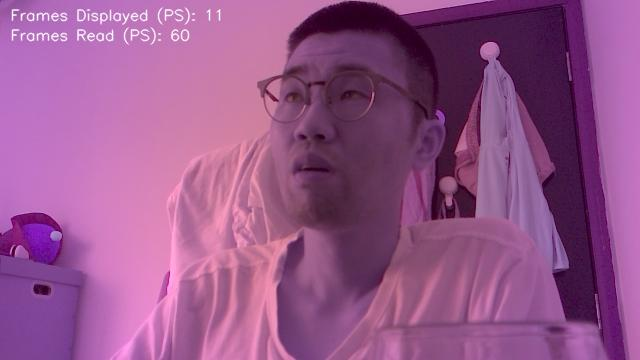

KeyboardInterrupt
Released Video Resource


In [15]:
face_detect()